In [1]:
%pylab inline
import gc
import galsim
import numpy as np
import astropy.io.fits as pyfits

import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


+ corrections for ellipticity, response and flux ratio 

$\frac{x}{1+x}=x-x^2$

$\frac{y}{1+x}=y(1-x)$

$\frac{a}{1+x}=a(1-x+x^2)$

$\frac{a^2}{(1+x)^2}=a^2(1-2x+3x^2)$

$\frac{(a+y)^2}{(1+x)^2}=a^2(1-2x+3x^2)+y^2+2ay(1-2x)$

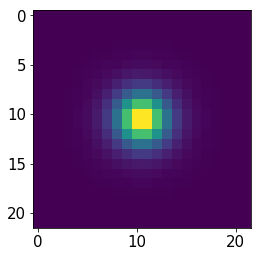

In [3]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
psfFWHM=0.60
scale=0.168
igal=39
beta=0.75

hsmCat=pyfits.getdata('sim20210301/galaxy_basic_psf%d/hsm-0-g1-2222.fits' %(psfFWHM*100))
rcutArray=np.maximum(np.minimum(np.int_(hsmCat['regauss_detR']*5),15),11)
rcut=rcutArray[igal]
    
beg=ngrid//2-rcut
end=beg+2*rcut
galImgAll=pyfits.getdata('sim20210301/galaxy_basic_psf%d/image-0-g1-2222.fits' %(psfFWHM*100))
img=galImgAll[igal//nx*ngrid+beg:igal//nx*ngrid+end,igal%nx*ngrid+beg:igal%nx*ngrid+end]/10.
plt.imshow(img)

In [4]:
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
fpTask0=fpfsBase.fpfsTask(psfData,beta=beta)

a0=fpTask0.measure(img)
C=12
b0=fpfsBase.fpfsM2E(a0,C)
print(a0,a0.dtype.names)
print(b0,b0.dtype.names)

(4.92436948, 0.06655082, -0.12931669, 3.62044369) ('fpfs_M00', 'fpfs_M22c', 'fpfs_M22s', 'fpfs_M40')
[[(0.00393225, -0.00764086, 0.05453075, 0.29096325)]] ('fpfs_e1', 'fpfs_e2', 'fpfs_RE', 'fpfs_s0')


In [5]:
# Noise
corPre      =   'corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
variance    =   1e-3
ngrid=64

if False:
    corIn=pyfits.getdata(corFname)*variance
    corIn=np.pad(corIn,(23-32+rcut,22-32+rcut))

    corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones(img.shape)))**2.)).real
    corIn=corIn*corNum
    powIn=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(corIn)).real)
else:
    powIn=np.load('corPre/noiPows2.npy',allow_pickle=True).item()['%s'%rcut]*variance
powModel=np.zeros((1,img.shape[0],img.shape[1]))
powModel[0]=powIn
#fpTask=fpfsBase.fpfsTask(psfData,noiModel=powModel)
fpTask=fpfsBase.fpfsTask(psfData,noiFit=powModel[0],beta=beta)

In [6]:
%%time
a=[]
for j in range(0,100):
    noiAll=pyfits.getdata('sim20210301/noise/noi%04d.fits' %j)*np.sqrt(variance*100.)
    imgList=[noiAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end]+img for i in range(ngal)]
    #plt.imshow(imgList[5])
    a.append(fpTask.measure(imgList))
    del noiAll,imgList
    gc.collect()
a=np.vstack(a)

CPU times: user 6min 5s, sys: 31.8 s, total: 6min 36s
Wall time: 6min 44s


In [7]:
print('variance of N00 from simulation and equation:')
print(np.var(a['fpfs_M00']),np.average(a['fpfs_N00N00']))
print('variance of N40 from simulation and equation:')
print(np.var(a['fpfs_M40']),np.average(a['fpfs_N40N40']))
print('variance of N22c from simulation and equation:')
print(np.var(a['fpfs_M22c']),np.average(a['fpfs_N22cN22c']))
print('variance of N22s from simulation and equation:')
print(np.var(a['fpfs_M22s']),np.average(a['fpfs_N22sN22s']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22c']*a['fpfs_M00'])-np.average(a['fpfs_M22c'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22c']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22s']*a['fpfs_M00'])-np.average(a['fpfs_M22s'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22s']))
print('cov of N40N00 from simulation and equation:')
print(np.average(a['fpfs_M40']*a['fpfs_M00'])-np.average(a['fpfs_M40'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N40']))

variance of N00 from simulation and equation:
7.814040631020074 7.85744964858492
variance of N40 from simulation and equation:
199.24751987585148 198.9730121596568
variance of N22c from simulation and equation:
15.389588917714908 15.153049602247743
variance of N22s from simulation and equation:
15.070809439583194 15.002049694933884
cov of N22cN00 from simulation and equation:
0.2677505047646632 0.26867084265233376
cov of N22cN00 from simulation and equation:
-0.2959870108077628 -0.2907976798502844
cov of N40N00 from simulation and equation:
5.572178665174235 5.887701794650615


In [8]:
%%time
b=fpfsBase.fpfsM2E(a,C)

CPU times: user 62.5 ms, sys: 46.8 ms, total: 109 ms
Wall time: 112 ms


In [9]:
print('Discrepancy in ellipticities and Response')
print('e1:',np.average(b['fpfs_e1'])-np.average(b0['fpfs_e1']),np.average(b['fpfs_e1'])/np.average(b0['fpfs_e1'])-1)
print('e2:',np.average(b['fpfs_e2'])-np.average(b0['fpfs_e2']),np.average(b['fpfs_e2'])/np.average(b0['fpfs_e2'])-1)
print('esq1:',np.average(b['fpfs_e1']**2.)-np.average(b0['fpfs_e1']**2.),np.average(b['fpfs_e1']**2.)/np.average(b0['fpfs_e1']**2.)-1)
print('esq2:',np.average(b['fpfs_e2']**2.)-np.average(b0['fpfs_e2']**2.),np.average(b['fpfs_e2']**2.)/np.average(b0['fpfs_e2']**2.)-1)
print('s0:',np.average(a['fpfs_M00']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print('s4:',np.average(a['fpfs_M40']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print('RE:',np.average(b['fpfs_RE'])-np.average(b0['fpfs_RE']),np.average(b['fpfs_RE'])/np.average(b0['fpfs_RE'])-1)

Discrepancy in ellipticities and Response
e1: -0.0007647538868406677 -0.194482622880353
e2: 0.0010392849932112065 -0.13601680699524477
esq1: 0.05270427910018349 3408.5062711130113
esq2: 0.05187443096183528 888.5240431620912
s0: -0.01922775928946263
s4: -0.014440936701400897
RE: 0.07056352034024004 1.2940134705930664


In [10]:
# e
ratio=a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.
e1=np.average((b['fpfs_e1']+a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1+ratio))
e2=np.average((b['fpfs_e2']+a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1+ratio))
print(e1-np.average(b0['fpfs_e1']),e1/np.average(b0['fpfs_e1'])-1)
print(e2-np.average(b0['fpfs_e2']),e2/np.average(b0['fpfs_e2'])-1)

8.703488117168742e-06 0.002213362006210584
0.00026671496408076176 -0.03490641934511618


In [12]:
e1sq=np.average((b['fpfs_e1']**2.-a['fpfs_N22cN22c']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e1']*a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
e2sq=np.average((b['fpfs_e2']**2.-a['fpfs_N22sN22s']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e2']*a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
print(e1sq-np.average(b0['fpfs_e1']**2.),e1sq/np.average(b0['fpfs_e1']**2.)-1)
print(e2sq-np.average(b0['fpfs_e2']**2.),e2sq/np.average(b0['fpfs_e2']**2.)-1)

0.007529935976643463 486.9781815757606
0.0067562112637916194 115.72283372087342


In [13]:
#s
s0=np.average((a['fpfs_M00']/(a['fpfs_M00']+C)+a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.)/(1+ratio))
s4=np.average((a['fpfs_M40']/(a['fpfs_M00']+C)+a['fpfs_N00N40']/(a['fpfs_M00']+C)**2.)/(1+ratio))
RE=(s0-s4+e1sq+e2sq)/np.sqrt(2.)

In [14]:
print(s0-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print(s4-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print(RE-np.average(b0['fpfs_RE']))

-0.0007515558318904048
0.0031533642216781954
0.007340636140871444


In [15]:
print(e1/RE-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(e2/RE-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

-0.008414788559956102
0.02093514087732387


In [16]:
np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE'])

-0.046789799432717674

In [17]:
np.average(b['fpfs_e2'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE'])

0.08734738505855942

In [18]:
a.dtype.names

('fpfs_M00',
 'fpfs_M22c',
 'fpfs_M22s',
 'fpfs_M40',
 'fpfs_N00N00',
 'fpfs_N22cN22c',
 'fpfs_N22sN22s',
 'fpfs_N40N40',
 'fpfs_N00N22c',
 'fpfs_N00N22s',
 'fpfs_N00N40')

In [19]:
def fpfsM2E(moments,const=1.,mcalib=0.,rev=False):
    """
    # Estimate FPFS ellipticities from fpfs moments

    Parameters:
    -----------
    moments:    input FPFS moments     [float array]
    const:      the weighting Constant [float]
    mcalib:     multiplicative bias [float array]

    Returns:
    -------------
    out :       an array of FPFS ellipticities,
                FPFS ellipticity response,
                FPFS flux ratio, and FPFS selection response
    """
    #Get weight
    weight  =   moments['fpfs_M00']+const
    #Ellipticity
    e1      =   moments['fpfs_M22c']/weight
    e2      =   moments['fpfs_M22s']/weight
    e1sq    =   e1*e1
    e2sq    =   e2*e2
    #FPFS flux ratio
    s0      =   moments['fpfs_M00']/weight
    s4      =   moments['fpfs_M40']/weight

    if rev:
        assert 'fpfs_N00N00' in moments.dtype.names
        assert 'fpfs_N00N22c' in moments.dtype.names
        assert 'fpfs_N00N22s' in moments.dtype.names
        ratio=  moments['fpfs_N00N00']/weight**2.
        e1  =   (e1+moments['fpfs_N00N22c']\
                /weight**2.)/(1+ratio)
        e2  =   (e2+moments['fpfs_N00N22s']\
                /weight**2.)/(1+ratio)
        e1sq=   (e1sq-moments['fpfs_N22cN22c']/weight**2.\
                +4.*e1*moments['fpfs_N00N22c']/weight**2.)\
                /(1.+3*ratio)
        e2sq=   (e2sq-moments['fpfs_N22sN22s']/weight**2.\
                +4.*e2*moments['fpfs_N00N22s']/weight**2.)\
                /(1.+3*ratio)
        s0  =   (s0+moments['fpfs_N00N00']\
                /weight**2.)/(1+ratio)
        s4  =   (s4+moments['fpfs_N00N40']\
                /weight**2.)/(1+ratio)

    #Response factor
    RE      =   1./np.sqrt(2.)*(s0-s4+e1sq+e2sq)
    types   =   [('fpfs_e1','>f8'),('fpfs_e2','>f8'),('fpfs_RE','>f8'),('fpfs_s0','>f8')]
    ellDat  =   np.array(np.zeros((moments.size,1)),dtype=types)
    ellDat['fpfs_e1']=e1
    ellDat['fpfs_e2']=e2
    ellDat['fpfs_RE']=RE
    ellDat['fpfs_s0']=s0
    return ellDat

b2=fpfsM2E(a,C,rev=True)

In [20]:
print(np.average(b2['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b2['fpfs_e2']-b0['fpfs_e2']))
print(np.average(b2['fpfs_RE']-b0['fpfs_RE']))
print(np.average(b2['fpfs_s0']-b0['fpfs_flux']))
print(np.average(b2['fpfs_e1'])/np.average(b2['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b2['fpfs_e2'])/np.average(b2['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

8.703488117169833e-06
0.00026671496408076794
0.007583506106323281


ValueError: no field of name fpfs_flux

In [ ]:
print(np.average(b['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b['fpfs_e2']-b0['fpfs_e2']))
print(np.average(b['fpfs_RE']-b0['fpfs_RE']))
print(np.average(b['fpfs_flux']-b0['fpfs_flux']))
print(np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b['fpfs_e2'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))